### 1. Import the libraries
As the first step, we need to import the required libraries.

In [1]:
import pandas as pd
import numpy as np

### 2. Load the dataset

In [2]:
df = pd.read_csv('../data/text-classification.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
df.shape

(2225, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


### 3. Exploratory Data Analysis

In [5]:
from collections import Counter

def countWord(list_of_words):            
    count = Counter()
    for sentence in list_of_words:
        for word in sentence.split():
            count[word] += 1
    
    return count

In [6]:
countWord(df['category'])

Counter({'tech': 401,
         'business': 510,
         'sport': 511,
         'entertainment': 386,
         'politics': 417})

In [7]:
counter = countWord(df['text'])
counter.most_common(5)

[('the', 52567), ('to', 24955), ('of', 19947), ('and', 18561), ('a', 18251)]

In [8]:
total_words = len(counter)
total_words

43771

### 4. Pre-processing the data
The actual data must meet certain conditions before being sent to the model. We will create a `pipeline`: a multi-level system where each level receives its data from the previous level and sends its results to the next level.

#### 4.1 Tranforming the data

We transform the `textual categories` into `index values`.

In [9]:
def category_transforming(df):
    category_mapper = dict(zip(np.unique(df["category"]), list(range(df['category'].nunique()))))
    category_inv_mapper = dict(zip(list(range(df['category'].nunique())), np.unique(df["category"])))
    
    return category_mapper, category_inv_mapper

In [10]:
category_mapper, category_inv_mapper = category_transforming(df)

In [11]:
category_ind = [category_mapper[i] for i in df['category']]
df['category_ind'] = category_ind
df.head()

,category,text,category_ind
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1


We can use another alternative with `scikit-learn` :

In [12]:
from sklearn.preprocessing import LabelEncoder

def category_transforming(list_of_categories):
    label_encoder = LabelEncoder()
    label_encoder.fit(df['category'])
    predicted_label = label_encoder.transform(list_of_categories)
    
    return predicted_label

In [13]:
category_ind = category_transforming(df['category'])
df['category_ind'] = category_ind
df.head()

,category,text,category_ind
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1


In [14]:
X = df['text']
Y = (df['category_ind']
     .to_numpy()
     .reshape(df['category_ind'].shape[0], 1))

### 5.  NLP Pipeline - Dataset preparation

In [15]:
import nltk

#### Step 1 -  Remove URL's

In [16]:
import re

def remove_links(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub("", text)

In [17]:
X = X.map(remove_links)
X.head()

0    tv future in the hands of viewers with home th...
1    worldcom boss  left books alone  former worldc...
2    tigers wary of farrell  gamble  leicester say ...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
Name: text, dtype: object

#### Step 2 -  Remove Punctuations

In [18]:
import string

def remove_punctuations(text):
    characters_to_remove = string.punctuation
    translator = str.maketrans("", "", characters_to_remove)
    clean_text = (text
                  .lower()
                  .translate(translator)
                 )
    
    return clean_text

In [19]:
X = X.map(remove_punctuations)
X.head()

0    tv future in the hands of viewers with home th...
1    worldcom boss  left books alone  former worldc...
2    tigers wary of farrell  gamble  leicester say ...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
Name: text, dtype: object

#### Step 3 - Stop words

In [20]:
# nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_stop_words(text):
    stop = stopwords.words("english")
    filtered_words = [word for word in text.split() if word not in stop]
    
    return " ".join(filtered_words)

In [21]:
X = X.map(remove_stop_words)
X.head()

0    tv future hands viewers home theatre systems p...
1    worldcom boss left books alone former worldcom...
2    tigers wary farrell gamble leicester say rushe...
3    yeading face newcastle fa cup premiership side...
4    ocean twelve raids box office ocean twelve cri...
Name: text, dtype: object

#### Step 4 - Tokenization then Stemming or Lemmatization ?

`Tokenization` splits a string into smaller entities such as words or single characters. Therefore, these are also referred to as tokens. <a href="https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization">Wikipedia</a> provides a nice example.

`Stemming` and `Lemmatization` are methods used by search engines and chatbots to analyze the meaning behind a word. `Stemming` uses the stem of the word, while `Lemmatization` uses the context in which the word is being used.

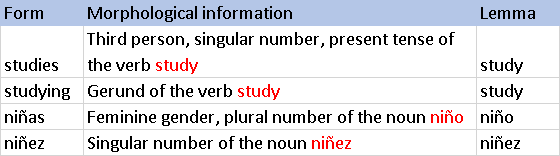

In this example, we will use `Stemming` for optimization and performance purposes.

In [22]:
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
from nltk.stem.porter import PorterStemmer

def get_tokenized_text(input_sentence):
    return nltk.word_tokenize(input_sentence)

def get_stemmed_text(word):
    stemmer = PorterStemmer()
    return stemmer.stem(word)

def convert_text_to_array(text_tokenized):
    text_tokenized = [get_tokenized_text(sentence) for sentence in X]
    for sentence in text_tokenized:
        for index, word in enumerate(sentence):
            sentence[index] = get_stemmed_text(word)
    
    return np.array(text_tokenized)

In [23]:
X = convert_text_to_array(X)
X[:5]

array([list(['tv', 'futur', 'hand', 'viewer', 'home', 'theatr', 'system', 'plasma', 'highdefinit', 'tv', 'digit', 'video', 'record', 'move', 'live', 'room', 'way', 'peopl', 'watch', 'tv', 'radic', 'differ', 'five', 'year', 'time', 'accord', 'expert', 'panel', 'gather', 'annual', 'consum', 'electron', 'show', 'la', 'vega', 'discuss', 'new', 'technolog', 'impact', 'one', 'favourit', 'pastim', 'us', 'lead', 'trend', 'programm', 'content', 'deliv', 'viewer', 'via', 'home', 'network', 'cabl', 'satellit', 'telecom', 'compani', 'broadband', 'servic', 'provid', 'front', 'room', 'portabl', 'devic', 'one', 'talkedabout', 'technolog', 'ce', 'digit', 'person', 'video', 'record', 'dvr', 'pvr', 'settop', 'box', 'like', 'us', 'tivo', 'uk', 'sky', 'system', 'allow', 'peopl', 'record', 'store', 'play', 'paus', 'forward', 'wind', 'tv', 'programm', 'want', 'essenti', 'technolog', 'allow', 'much', 'personalis', 'tv', 'also', 'builtin', 'highdefinit', 'tv', 'set', 'big', 'busi', 'japan', 'us', 'slower', 't

In [24]:
X.shape, Y.shape

((2225,), (2225, 1))

#### Step 5. - Tokenization with Keras

`Keras-Tokenizer` allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector.

This means that the data is already cleaned, lemmatized etc.

In [25]:
from keras.preprocessing.text import Tokenizer

def get_sequence_of_tokens(input_sentences):
    tokenizer = Tokenizer()
    
    tokenizer.fit_on_texts(input_sentences)   
    sentences_to_sequences = tokenizer.texts_to_sequences(input_sentences)
    
    return sentences_to_sequences

In [26]:
X = get_sequence_of_tokens(X)
X[:5]

[[118,
  215,
  356,
  1049,
  66,
  1075,
  106,
  4056,
  1219,
  118,
  174,
  238,
  81,
  99,
  193,
  1315,
  47,
  6,
  542,
  118,
  2574,
  242,
  136,
  3,
  14,
  182,
  909,
  1241,
  1271,
  628,
  192,
  692,
  30,
  1272,
  2575,
  718,
  7,
  72,
  840,
  9,
  788,
  9435,
  8,
  188,
  1183,
  247,
  447,
  737,
  1049,
  859,
  66,
  190,
  1220,
  1811,
  1184,
  27,
  400,
  41,
  246,
  914,
  1315,
  1036,
  354,
  9,
  14945,
  72,
  2198,
  174,
  204,
  238,
  81,
  5656,
  3368,
  3501,
  535,
  19,
  8,
  4239,
  29,
  1316,
  106,
  170,
  6,
  81,
  741,
  23,
  3253,
  536,
  3502,
  118,
  247,
  32,
  1610,
  72,
  170,
  93,
  3744,
  118,
  5,
  3608,
  1219,
  118,
  51,
  197,
  129,
  485,
  8,
  2517,
  25,
  196,
  989,
  1219,
  442,
  6,
  536,
  3502,
  2009,
  5,
  2157,
  6067,
  190,
  860,
  1461,
  103,
  709,
  14946,
  714,
  8,
  190,
  1220,
  1811,
  27,
  744,
  194,
  434,
  1383,
  803,
  67,
  775,
  1868,
  1049,
  4240,
  860,
 

#### 6.Padding the Sequences

Now that we have generated a data-set which contains sequence of tokens, it is possible that different sequences have different lengths. Before starting training the model, we need to pad the sequences and make their lengths equal. We can use pad_sequence function of Keras for this purpose.

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_padded_sequences(input_sequences, max_sequence = None):
    if max_sequence is None:
        max_sequence = max([len(x) for x in input_sequences])
    input_sequences = pad_sequences(input_sequences, maxlen = max_sequence, padding = "post", truncating = "post")
    
    return input_sequences, max_sequence

In [28]:
X, max_sequence = generate_padded_sequences(X)
X[:5]

array([[ 118,  215,  356, ...,    0,    0,    0],
       [1497,  605,  359, ...,    0,    0,    0],
       [2579, 5278, 3074, ...,    0,    0,    0],
       [8144,  127, 1106, ...,    0,    0,    0],
       [2933, 3903, 3372, ...,    0,    0,    0]])

#### 7. Splitting the data

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [30]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1780, 2219) (1780, 1)
(445, 2219) (445, 1)


### 6.  LSTMs for Text Generation

Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.

The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.

LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively. To learn more about LSTMs, here is a great post. Lets architecture a LSTM model in our code. I have added total three layers in the model.

1. Input Layer : Takes the sequence of words as input
2. LSTM Layer : Computes the output using LSTM units. I have added 100 units in the layer, but this number can be fine tuned later.
3. Dropout Layer : A regularisation layer which randomly turns-off the activations of some neurons in the LSTM layer. It helps in preventing over fitting. (Optional Layer)
4. Output Layer : Computes the probability of the best possible next word as output

We will run this model for total 100 epoochs but it can be experimented further.

In [35]:
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def create_model(total_words, max_sequence):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        movie_mapper: dict that maps movie id's to movie indices
    """
    
    model = Sequential()
    
    # Add Input Embedding, Hidden and Ouput Layer
    model.add(Embedding(input_dim = total_words, output_dim = 100, input_length = max_sequence))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(units = 100, dropout = 0.2, recurrent_dropout=0.2))
    model.add(Dense(units = 1, activation='softmax'))
    
    loss = BinaryCrossentropy(from_logits = False)
    optim = Adam(learning_rate = 0.001)
    metrics = ["accuracy"]

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [36]:
model = create_model(total_words, max_sequence)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2219, 100)         4377100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,457,601
Trainable params: 4,457,601
Non-trainable params: 0
_________________________________________________________________


Let's train our model now

In [37]:
history = model.fit(X_train, y_train, epochs = 2, batch_size = 64, validation_split=0.2, callbacks = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], verbose = 5)

Epoch 1/2
Epoch 2/2


Let's see the history of the model

In [38]:
print(history.history)

{'loss': [-3.980952501296997, -12.640002250671387], 'accuracy': [0.1755618005990982, 0.1755618005990982], 'val_loss': [-9.752564430236816, -15.502312660217285], 'val_accuracy': [0.15449437499046326, 0.15449437499046326]}


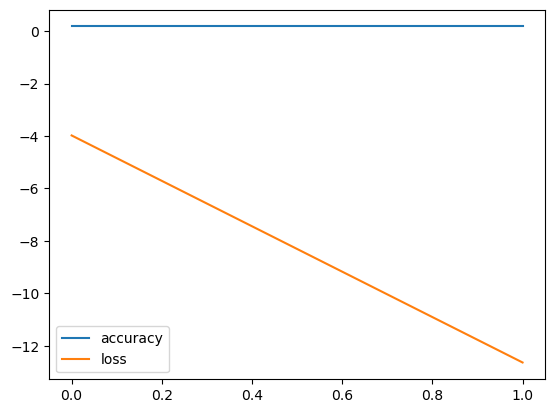

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['accuracy', 'loss'])

plt.show()

Let's test our model

In [40]:
accuracy = model.evaluate(X_test, y_test)

14/14 [==============================] - 9s 668ms/step - loss: -15.1974 - accuracy: 0.1820


### 7. Test with a New Complaint

In [42]:
predictions = model.predict(X_test)

array([1.], dtype=float32)